# Natural Language Processing with Disaster Tweets

# Работу выполнили: Яснев Максим, Петров Александр. Ученики Школы::Кода

# Ссылка на Kaggle: https://www.kaggle.com/competitions/nlp-getting-started/overview

# Ссылка на GitHub: https://github.com/Maxyasnev/Natural-Language-Processing-with-Disaster-Tweets

In [1]:
#Импорт библиотек
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from catboost import Pool, CatBoostClassifier

In [2]:
#Считывание файлов
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
#Первичный анализ данных
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
#Анализ типов данных
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
#Проверка данных на пропуски
train_data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test_data.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

# Данные

У признака "location" слишком много пропущенных значений, а признак "id" — это простой серийный номер, поэтому их отбросим. Некоторые текстовые значения (твиты) повторяются — оставим только одно, если все дубликаты имеют одну и ту же цель, удалим все, если у них разные цели, иначе они запутают нашу модель.

Признак "keyword" является категориальным и имеет пропущенные значения. CatBoost может работать с несколькими категориальными признакамми по отдельности, но не одновременно. Кроме того, "keyword" имеет большое количество категорий и использовать One Hot Encoded или дамми переменные бесмыссленно. Поэтому закодируем его с помощью LabelEncoder, рассматривая значения np.nan как отдельную категорию.

# Импорт библиотек

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from catboost import Pool, CatBoostClassifier

In [10]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Первичный анализ данных

In [11]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [15]:
train_data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [16]:
test_data.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

# Визуализация

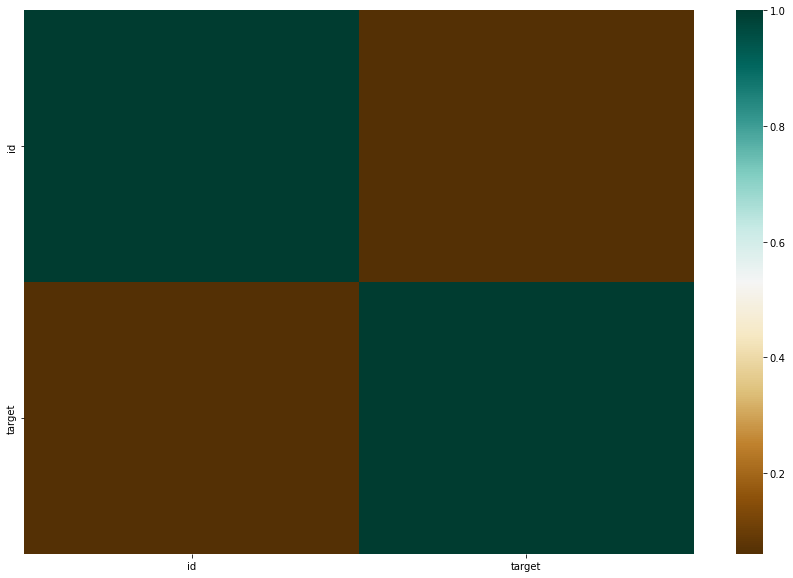

In [17]:
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df_corr = train_data.corr()

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, cmap = "BrBG",ax=ax)
plt.show()

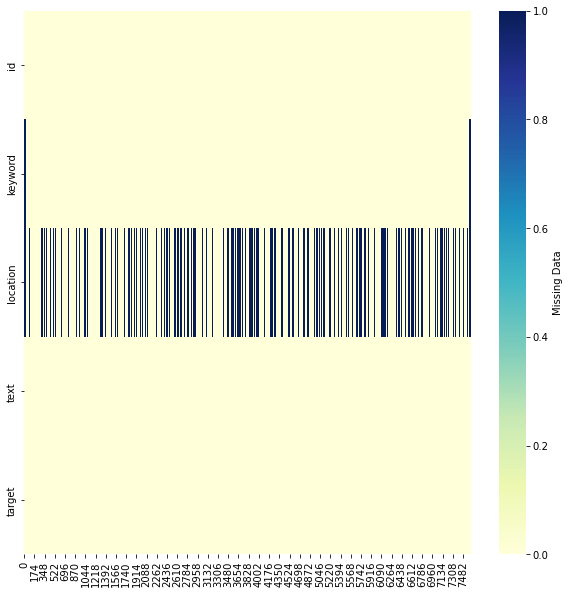

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

<AxesSubplot:>

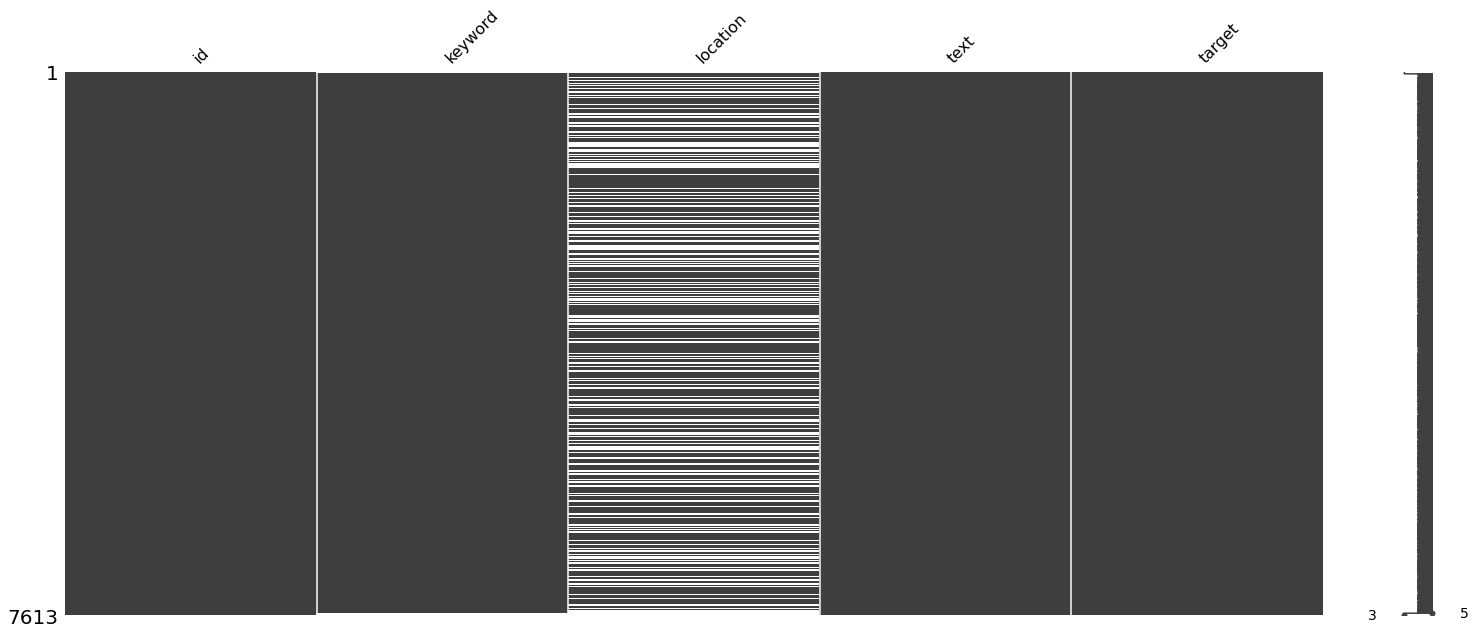

In [19]:
import missingno as msno
msno.matrix(train_data)

<AxesSubplot:>

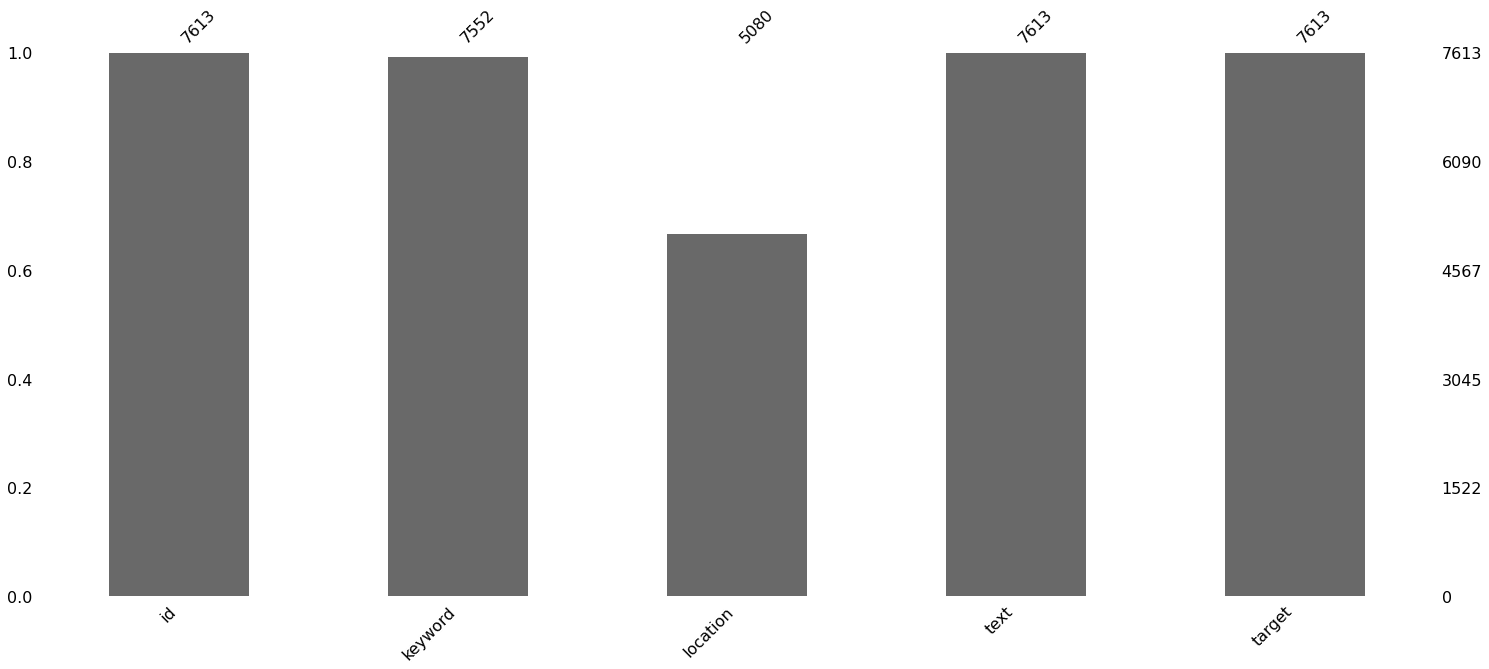

In [20]:
msno.bar(train_data)

# Данные

###
У признака "location" слишком много пропущенных значений, а признак "id" — это простой серийный номер, поэтому их отбросим. Некоторые текстовые значения (твиты) повторяются — оставим только одно, если все дубликаты имеют одну и ту же цель, удалим все, если у них разные цели, иначе они запутают нашу модель.

Признак "keyword" является категориальным и имеет пропущенные значения. CatBoost может работать с несколькими категориальными признакамми по отдельности, но не одновременно. Кроме того, "keyword" имеет большое количество категорий и использовать One Hot Encoded или дамми переменные бесмыссленно. Поэтому закодируем его с помощью LabelEncoder, рассматривая значения np.nan как отдельную категорию.

In [21]:
print(train_data.duplicated(['text', 'target']).sum())
print(train_data.duplicated(['text']).sum())

92
110


In [22]:
train_data = train_data.drop(['id', 'location'], axis=1)
test_data = test_data.drop(['id', 'location'], axis=1)
train_data = train_data.drop_duplicates(["text", "target"])
train_data = train_data.drop(index=train_data[train_data.duplicated('text', keep=False)].index)

In [23]:
encoder = LabelEncoder()
train_data['keyword'] = encoder.fit_transform(train_data['keyword'])
test_data['keyword'] = encoder.transform(test_data['keyword'])

# Модель ML

Чтобы создать модель CatBoost, лучше всего «объединить» признаки. В этом случае это необходимо сделать, потому что один из признаков является категориальным, который может обрабатываться только путем объединения.

In [24]:
train_pool = Pool(train_data[['keyword', 'text']], label=train_data[['target']], text_features=['text'])
test_pool = Pool(test_data, text_features=['text'])

Здесь мы создаем объекты Pool из данных тренировочного и тестового наборов для использования с CatBoost.
train_data[['keyword', 'text']] обращается к столбцам 'keyword' и 'text' в тренировочных данных. 
train_data[['target']] обращается к столбцу 'target', который является целевым столбцом для обучения модели.
test_data представляет собой тестовые данные, и мы используем только столбец 'text' в качестве текстовых признаков.
text_features=['text'] указывает, что столбец 'text' должен быть рассмотрен как текстовый признак в Pool. 
Это позволяет CatBoost обрабатывать текстовые данные в качестве особого типа признаков при обучении модели.

# Параметр verbose=0 используется для отключения вывода прогресса обучения.

In [25]:
clf = CatBoostClassifier(random_state=42)
clf.fit(train_pool, verbose=0)
y_pred = clf.predict(test_pool)

# Предсказание

In [26]:
sample = pd.read_csv('sample_submission.csv')
sample['target'] = y_pred
sample.to_csv('solution.csv', index=False)